## 1. Initial Setup

### 1.1 Imports

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table

import fitsio
from scipy import interpolate
import glob
import math
import os

import h5py
import bisect

import scipy.constants as sc

import sys
sys.path.append('../python')
import AlasBabylon

import matplotlib.pyplot as plt

%matplotlib inline


### 1.2 Pseudo-hexadecimal translations

In [2]:
# Python dictionaries to help in translating between
#  spec ID entries ("s" numbers) and S. Shectman's
#  pseudo-hex notation.

apernum_to_ShectHex_dict = \
{
    '1':'01',   '15':'11',   '29':'21',   '43':'31',
    '2':'02',   '16':'12',   '30':'22',   '44':'32',
    '3':'03',   '17':'13',   '31':'23',   '45':'33',
    '4':'04',   '18':'14',   '32':'24',   '46':'34',
    '5':'05',   '19':'15',   '33':'25',   '47':'35',
    '6':'06',   '20':'16',   '34':'26',   '48':'36',
    '7':'07',   '21':'17',   '35':'27',   '49':'37',
    '8':'08',   '22':'18',   '36':'28',   '50':'38',
    '9':'09',   '23':'19',   '37':'29',   '51':'39',
    '10':'0A',   '24':'1A',   '38':'2A',   '52':'3A',
    '11':'0B',   '25':'1B',   '39':'2B',   '53':'3B',
    '12':'0C',   '26':'1C',   '40':'2C',   '54':'3C',
    '13':'0D',   '27':'1D',   '41':'2D',   '55':'3D',
    '14':'0E',   '28':'1E',   '42':'2E',   '56':'3E',
    '57':'41',   '71':'51',   '85':'61',   '99':'71',
    '58':'42',   '72':'52',   '86':'62',   '100':'72',
    '59':'43',   '73':'53',   '87':'63',   '101':'73',
    '60':'44',   '74':'54',   '88':'64',   '102':'74',
    '61':'45',   '75':'55',   '89':'65',   '103':'75',
    '62':'46',   '76':'56',   '90':'66',   '104':'76',
    '63':'47',   '77':'57',   '91':'67',   '105':'77',
    '64':'48',   '78':'58',   '92':'68',   '106':'78',
    '65':'49',   '79':'59',   '93':'69',   '107':'79',
    '66':'4A',   '80':'5A',   '94':'6A',   '108':'7A',
    '67':'4B',   '81':'5B',   '95':'6B',   '109':'7B',
    '68':'4C',   '82':'5C',   '96':'6C',   '110':'7C',
    '69':'4D',   '83':'5D',   '97':'6D',   '111':'7D',
    '70':'4E',   '84':'5E',   '98':'6E',   '112':'7E',
    
}


shectHex_to_apernum_dict = \
{
    '01':'1',   '11':'15',   '21':'29',   '31':'43',
    '02':'2',   '12':'16',   '22':'30',   '32':'44',
    '03':'3',   '13':'17',   '23':'31',   '33':'45',
    '04':'4',   '14':'18',   '24':'32',   '34':'46',
    '05':'5',   '15':'19',   '25':'33',   '35':'47',
    '06':'6',   '16':'20',   '26':'34',   '36':'48',
    '07':'7',   '17':'21',   '27':'35',   '37':'49',
    '08':'8',   '18':'22',   '28':'36',   '38':'50',
    '09':'9',   '19':'23',   '29':'37',   '39':'51',
    '0A':'10',   '1A':'24',   '2A':'38',   '3A':'52',
    '0B':'11',   '1B':'25',   '2B':'39',   '3B':'53',
    '0C':'12',   '1C':'26',   '2C':'40',   '3C':'54',
    '0D':'13',   '1D':'27',   '2D':'41',   '3D':'55',
    '0E':'14',   '1E':'28',   '2E':'42',   '3E':'56',
    '41':'57',   '51':'71',   '61':'85',   '71':'99',
    '42':'58',   '52':'72',   '62':'86',   '72':'100',
    '43':'59',   '53':'73',   '63':'87',   '73':'101',
    '44':'60',   '54':'74',   '64':'88',   '74':'102',
    '45':'61',   '55':'75',   '65':'89',   '75':'103',
    '46':'62',   '56':'76',   '66':'90',   '76':'104',
    '47':'63',   '57':'77',   '67':'91',   '77':'105',
    '48':'64',   '58':'78',   '68':'92',   '78':'106',
    '49':'65',   '59':'79',   '69':'93',   '79':'107',
    '4A':'66',   '5A':'80',   '6A':'94',   '7A':'108',
    '4B':'67',   '5B':'81',   '6B':'95',   '7B':'109',
    '4C':'68',   '5C':'82',   '6C':'96',   '7C':'110',
    '4D':'69',   '5D':'83',   '6D':'97',   '7D':'111',
    '4E':'70',   '5E':'84',   '6E':'98',   '7E':'112'
}

### 1.3 Night to spectro run directory lookup table

In [3]:
# Check these with Huan...
night_to_runDir_dict = \
{
    '1988-06-11':'8811',
    '1988-08-11':'8811',
    '1988-09-11':'8811',
    
    '1989-02-05':'8905',
    '1989-05-05':'8905',
    '1989-06-05':'8905',

    '1989-01-10':'8910',
    '1989-02-10':'8910',
    '1989-03-10':'8910',
    '1989-04-10':'8910',
    '1989-06-10':'8910',
    
    '1990-01-04':'9003',
    '1990-02-04':'9003',

    '1990-05-09':'9010',
    '1990-06-09':'9010',
    
    '1990-03-10':'9010',
    '1990-04-10':'9010',
    '1990-05-10':'9010',
    '1990-09-10':'9010',
    '1990-11-10':'9010',
    '1990-12-10':'9010',
    
    '1991-03-03':'9104',
    '1991-04-03':'9104',
    '1991-05-03':'9104',
    '1991-07-03':'9104',

    '1991-03-04':'9104',
    '1991-04-04':'9104',
    '1991-05-04':'9104',
    '1991-06-04':'9104',
    '1991-07-04':'9104',
    '1991-08-04':'9104',
    '1991-09-04':'9104',
    '1991-12-04':'9104',
    
    '1991-01-10':'9110',
    '1991-02-10':'9110',
    '1991-03-10':'9110',
    '1991-04-10':'9110',
    '1991-05-10':'9110',
    '1991-06-10':'9110',
    '1991-07-10':'9110',
    '1991-08-10':'9110',
    '1991-09-10':'9110',
    
    '1992-02-03':'9204',
    
    '1992-01-04':'9204',
    '1992-02-04':'9204',
    '1992-03-04':'9204',
    '1992-04-04':'9204',
    '1992-05-04':'9204',
    '1992-06-04':'9204',
    '1992-07-04':'9204',
    '1992-08-04':'9204',
    '1992-09-04':'9204',
    '1992-10-04':'9204',

    '1992-08-09':'9209',
    '1992-09-09':'9209',
    
    '1993-04-03':'9303',
    '1993-05-03':'9303',
    '1993-06-03':'9303',
    '1993-07-03':'9303',
    '1993-08-03':'9303',
    '1993-09-03':'9303',

    '1993-03-09':'9310',
    '1993-10-09':'9310',
    '1993-11-09':'9310',
    '1993-12-09':'9310',
    
    '1993-03-10':'9310',
    '1993-04-10':'9310',
    '1993-05-10':'9310',
    '1993-08-10':'9310',
    '1993-09-10':'9310',
    '1993-10-10':'9310',
    '1993-11-10':'9310',
    '1993-12-10':'9310',
    
    '1994-10-03':'9404',
    '1994-11-03':'9404',
    '1994-12-03':'9404',

    '1994-04-04':'9404',
    '1994-06-04':'9404',
    '1994-07-04':'9404',
    '1994-08-04':'9404',
    '1994-09-04':'9404',
    '1994-10-04':'9404',
    '1994-11-04':'9404',
    '1994-12-04':'9404',

    '1994-01-09':'9410',
    '1994-02-09':'9410',

    '1994-01-10':'9410',
    '1994-02-10':'9410',
    '1994-03-10':'9410',
    '1994-04-10':'9410',
    '1994-05-10':'9410',
    '1994-06-10':'9410',
    '1994-07-10':'9410',
    
    '1995-01-03':'9410',
    '1995-02-03':'9410'
}


### 1.4 Standard paths

In [4]:
lcrs_cat_dirname = '../data/cats'

lcrs_cat_cat_filename = 'Vizier_LCRS_1996_VII_203_catalog.csv'
lcrs_cat_flds_filename = 'Vizier_LCRS_1996_VII_203_fields.csv'

lcrs_cat_cat_fullfilename = os.path.join(lcrs_cat_dirname, lcrs_cat_cat_filename)
lcrs_cat_flds_fullfilename = os.path.join(lcrs_cat_dirname, lcrs_cat_flds_filename)

lcrs_spectra_dirname = '../data/spectraFITS'

## 2. User input

In [5]:
# LCRS spectrum to identify and plot...
#lcrs_objname = 'LCRS B013916.9-445123'
lcrs_objname = 'LCRS B040659.9-385922'

# Directory to which to send output (plots, CSV files, etc.).
#  In this case, we will use the home directory
#  (but the user may change that as seems suitable)...
output_dirname = os.path.expanduser('~')

## 3. Identify the object in the LCRS catalog

In [6]:
# Read lcrs_cat_cat_fullfilenameCSV file into Pandas dataframe...
df_lcrscat = pd.read_csv(lcrs_cat_cat_fullfilename)
df_lcrscat.head(5)

,recno,Field,p,mag,Scan,mc,RA1950,DE1950,s,type,cz,e_cz,sf,gsf,cz55,LCRS,Simbad,_RA.icrs,_DE.icrs
0,1,0000-42E,496.0,17.52,0000-4225,18.36,00 08 30.09,-42 25 55.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000830.0-422555,Simbad,00 11 01.27,-42 09 13.9
1,2,0000-42E,583.0,18.02,0000-4212,18.46,00 08 31.98,-42 12 22.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000831.9-421222,Simbad,00 11 03.17,-41 55 41.3
2,3,0000-42E,514.0,17.92,0000-4237,18.27,00 08 33.01,-42 33 45.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000833.0-423345,Simbad,00 11 04.16,-42 17 04.1
3,4,0000-42E,512.2,15.70,0000-4147,14.16,00 08 33.20,-41 48 53.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000833.2-414853,Simbad,00 11 04.42,-41 32 11.7
4,5,0000-42E,501.0,17.51,0000-4225,18.30,00 08 33.45,-42 29 20.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B000833.4-422920,Simbad,00 11 04.61,-42 12 39.3


In [7]:
# Let's also create raDeg1950, decDeg1950 columns based on the RA1950, DE1950 columns...
df_lcrscat['raHMS1950'] = df_lcrscat['RA1950'].str.replace(' ', ':')
df_lcrscat['decDMS1950'] = df_lcrscat['DE1950'].str.replace(' ', ':')
df_lcrscat['raDeg1950'] = df_lcrscat['raHMS1950'].apply(AlasBabylon.HMSToDeg)
df_lcrscat['decDeg1950'] = df_lcrscat['decDMS1950'].apply(AlasBabylon.DMSToDeg)
df_lcrscat.head(5)

,recno,Field,p,mag,Scan,mc,RA1950,DE1950,s,type,...,gsf,cz55,LCRS,Simbad,_RA.icrs,_DE.icrs,raHMS1950,decDMS1950,raDeg1950,decDeg1950
0,1,0000-42E,496.0,17.52,0000-4225,18.36,00 08 30.09,-42 25 55.5,NaN,NaN,...,NaN,NaN,B000830.0-422555,Simbad,00 11 01.27,-42 09 13.9,00:08:30.09,-42:25:55.5,2.125375,-42.432083
1,2,0000-42E,583.0,18.02,0000-4212,18.46,00 08 31.98,-42 12 22.9,NaN,NaN,...,NaN,NaN,B000831.9-421222,Simbad,00 11 03.17,-41 55 41.3,00:08:31.98,-42:12:22.9,2.133250,-42.206361
2,3,0000-42E,514.0,17.92,0000-4237,18.27,00 08 33.01,-42 33 45.7,NaN,NaN,...,NaN,NaN,B000833.0-423345,Simbad,00 11 04.16,-42 17 04.1,00:08:33.01,-42:33:45.7,2.137542,-42.562694
3,4,0000-42E,512.2,15.70,0000-4147,14.16,00 08 33.20,-41 48 53.3,NaN,NaN,...,NaN,NaN,B000833.2-414853,Simbad,00 11 04.42,-41 32 11.7,00:08:33.20,-41:48:53.3,2.138333,-41.814806
4,5,0000-42E,501.0,17.51,0000-4225,18.30,00 08 33.45,-42 29 20.9,NaN,NaN,...,NaN,NaN,B000833.4-422920,Simbad,00 11 04.61,-42 12 39.3,00:08:33.45,-42:29:20.9,2.139375,-42.489139


In [8]:
# Let's create a mask that only includes LCRS objects with a measured LCRS redshift:
mask_redshift = ~df_lcrscat['cz'].isnull()
df_lcrscat[mask_redshift].head(5)

,recno,Field,p,mag,Scan,mc,RA1950,DE1950,s,type,...,gsf,cz55,LCRS,Simbad,_RA.icrs,_DE.icrs,raHMS1950,decDMS1950,raDeg1950,decDeg1950
17,18,0000-42E,631.0,16.48,0000-4122,17.33,00 08 48.00,-41 28 04.6,646,c,...,0.232,NaN,B000848.0-412804,Simbad,00 11 19.19,-41 11 23.1,00:08:48.00,-41:28:04.6,2.200000,-41.467944
18,19,0000-42E,536.0,16.91,0000-4237,17.60,00 08 49.25,-42 33 31.7,637,c,...,0.348,NaN,B000849.2-423331,Simbad,00 11 20.33,-42 16 50.2,00:08:49.25,-42:33:31.7,2.205208,-42.558806
19,20,0000-42E,519.0,16.81,0000-4225,17.68,00 08 49.48,-42 26 10.0,638,c,...,0.298,NaN,B000849.4-422610,Simbad,00 11 20.57,-42 09 28.5,00:08:49.48,-42:26:10.0,2.206167,-42.436111
31,32,0000-42E,552.0,17.03,0000-4237,17.72,00 09 01.26,-42 33 17.3,636,c,...,0.348,NaN,B000901.2-423317,Simbad,00 11 32.29,-42 16 35.8,00:09:01.26,-42:33:17.3,2.255250,-42.554806
33,34,0000-42E,533.0,16.89,0000-4225,17.77,00 09 01.80,-42 20 10.0,639,c,...,0.333,NaN,B000901.8-422010,Simbad,00 11 32.85,-42 03 28.5,00:09:01.80,-42:20:10.0,2.257500,-42.336111


In [9]:
# Identify LCRS object of interest:
lcrs_objname_trunc =  lcrs_objname.split()[1]
df_lcrscat_obj = df_lcrscat[(df_lcrscat.LCRS == lcrs_objname_trunc)]

n_match = len(df_lcrscat_obj)

if n_match == 0:
    text = """*** ERROR:  No matches found for %s... ***""" % (lcrs_objname)
    print('\n'+text+'\n')
elif n_match == 1:
    text = """INFO:  Single match found for %s...""" % (lcrs_objname)
    print('\n'+text+'\n')
elif n_match > 1:
    text = """*** WARNING:  Multiple matches found for %s...  Choosing first in list. ***""" % (lcrs_objname)
    print('\n'+text+'\n')

if n_match > 0:
    lcrscat_obj_info = df_lcrscat_obj.iloc[0]
    text = """Here is the info from %s for %s:""" % (lcrs_cat_cat_fullfilename, lcrs_objname)
    print(text)
    print(lcrscat_obj_info)


INFO:  Single match found for LCRS B040659.9-385922...

Here is the info from ../data/cats/Vizier_LCRS_1996_VII_203_catalog.csv for LCRS B040659.9-385922:
recno                    27015
Field                 0354-39M
p                        803.0
mag                      16.12
Scan                 0354-3900
mc                       16.89
RA1950             04 06 59.92
DE1950             -38 59 22.9
s                          425
type                         e
cz                     17199.0
e_cz                      55.0
sf                       0.808
gsf                      0.854
cz55                       NaN
LCRS          B040659.9-385922
Simbad                  Simbad
_RA.icrs           04 08 46.03
_DE.icrs           -38 51 31.8
raHMS1950          04:06:59.92
decDMS1950         -38:59:22.9
raDeg1950            61.749667
decDeg1950          -38.989694
Name: 27014, dtype: object


In [10]:
# ... and extract the RA, DEC, redshift, spectro field, spectro ID, and 
#     spectra type ([c]ontinuum, [e]mission, etc.)
raHMS1950 = lcrscat_obj_info.RA1950
decDMS1950 = lcrscat_obj_info.DE1950
raDeg1950 = lcrscat_obj_info.raDeg1950
decDeg1950 = lcrscat_obj_info.decDeg1950
cz = lcrscat_obj_info.cz
z = cz / (sc.c/1000.)
specfield = lcrscat_obj_info.Field   
spectype = lcrscat_obj_info.type
specID = lcrscat_obj_info.s        # Check this...
print(raHMS1950, decDMS1950, raDeg1950, decDeg1950, specfield, specID, cz, z, spectype)
#print(raHMS1950, decDMS1950, specfield, specID, cz, z, spectype)

04 06 59.92 -38 59 22.9 61.74966666666667 -38.989694444444446 0354-39M 425 17199.0 0.05736968873313018 e


## 4. Identify the LCRS spectroscopic field in which the LCRS object lies

In [11]:
# Read lcrs_cat_flds_fullfilename CSV file into Pandas dataframe...
df_lcrsflds = pd.read_csv(lcrs_cat_flds_fullfilename)
df_lcrsflds.head(5)

,recno,Field,RA1,RA2,DE1,DE2,m1,m2,mcen,Nfib,Ngal,f,Night,Frame,plate,_RA.icrs,_DE.icrs
0,1,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 08 28.66,00 15 43.22,-42 44 04.6,-41 15 28.8,16.19,17.49,18.34,50,37,0.31,1989-03-10,163,SSA007-600; 0000-42E,00 10 59.82,-42 27 23.0
1,2,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 01 25.73,00 08 28.66,-42 44 04.6,-41 15 28.8,16.19,17.49,18.34,50,40,0.35,1989-02-10,149,SSA010-200; 0000-42W,00 03 58.77,-42 27 22.2
2,3,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 33 03.82,00 41 21.14,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,81,0.88,1993-03-10,192,SSA064-200; 0015-42E,00 35 28.43,-42 27 42.6
3,4,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 23 41.14,00 33 03.82,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,107,0.85,1994-02-10,178,SSA063-200; 0015-42M,00 26 08.24,-42 27 37.3
4,5,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 15 43.22,00 23 41.14,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,105,0.56,1994-01-10,164,SSA062-200; 0015-42W,00 18 12.44,-42 27 34.1


In [12]:
# Let's also create raDeg1950, decDeg1950 columns based on the RA1950, DE1950 columns...
df_lcrsflds['raHMS1950_1'] = df_lcrsflds['RA1'].str.replace(' ', ':')
df_lcrsflds['raHMS1950_2'] = df_lcrsflds['RA2'].str.replace(' ', ':')
df_lcrsflds['decDMS1950_1'] = df_lcrsflds['DE1'].str.replace(' ', ':')
df_lcrsflds['decDMS1950_2'] = df_lcrsflds['DE2'].str.replace(' ', ':')
df_lcrsflds['raDeg1950_1'] = df_lcrsflds['raHMS1950_1'].apply(AlasBabylon.HMSToDeg)
df_lcrsflds['raDeg1950_2'] = df_lcrsflds['raHMS1950_2'].apply(AlasBabylon.HMSToDeg)
df_lcrsflds['decDeg1950_1'] = df_lcrsflds['decDMS1950_1'].apply(AlasBabylon.DMSToDeg)
df_lcrsflds['decDeg1950_2'] = df_lcrsflds['decDMS1950_2'].apply(AlasBabylon.DMSToDeg)
df_lcrsflds.head(5)

,recno,Field,RA1,RA2,DE1,DE2,m1,m2,mcen,Nfib,...,_RA.icrs,_DE.icrs,raHMS1950_1,raHMS1950_2,decDMS1950_1,decDMS1950_2,raDeg1950_1,raDeg1950_2,decDeg1950_1,decDeg1950_2
0,1,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 08 28.66,00 15 43.22,-42 44 04.6,-41 15 28.8,16.19,17.49,18.34,50,...,00 10 59.82,-42 27 23.0,00:08:28.66,00:15:43.22,-42:44:04.6,-41:15:28.8,2.119417,3.930083,-42.734611,-41.258000
1,2,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 01 25.73,00 08 28.66,-42 44 04.6,-41 15 28.8,16.19,17.49,18.34,50,...,00 03 58.77,-42 27 22.2,00:01:25.73,00:08:28.66,-42:44:04.6,-41:15:28.8,0.357208,2.119417,-42.734611,-41.258000
2,3,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 33 03.82,00 41 21.14,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,...,00 35 28.43,-42 27 42.6,00:33:03.82,00:41:21.14,-42:44:13.9,-41:14:42.7,8.265917,10.338083,-42.737194,-41.245194
3,4,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 23 41.14,00 33 03.82,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,...,00 26 08.24,-42 27 37.3,00:23:41.14,00:33:03.82,-42:44:13.9,-41:14:42.7,5.921417,8.265917,-42.737194,-41.245194
4,5,http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...,00 15 43.22,00 23 41.14,-42 44 13.9,-41 14 42.7,14.93,17.63,18.78,112,...,00 18 12.44,-42 27 34.1,00:15:43.22,00:23:41.14,-42:44:13.9,-41:14:42.7,3.930083,5.921417,-42.737194,-41.245194


In [13]:
# Identify LCRS field of interest:

# This will fail for fields that straddle RA=360deg/0deg,
#  but this will do for now...
mask_field = ( (raDeg1950 >= df_lcrsflds.raDeg1950_1) & \
               (raDeg1950 <= df_lcrsflds.raDeg1950_2) & \
               (decDeg1950 >= df_lcrsflds.decDeg1950_1) & \
               (decDeg1950 <= df_lcrsflds.decDeg1950_2) ) 

df_lcrsflds_obj = df_lcrsflds[mask_field]

n_flds = len(df_lcrsflds_obj)

if n_flds == 0:
    text = """*** ERROR:  No spectoscopic fields found for %s... ***""" % (lcrs_objname)
    print('\n'+text+'\n')
elif n_flds == 1:
    text = """INFO:  Single spectoscopic fields found found for %s...""" % (lcrs_objname)
    print('\n'+text+'\n')
elif n_flds > 1:
    text = """*** WARNING:  Multiple spectoscopic fields found found for %s...  Choosing first in list. ***""" % (lcrs_objname)
    print('\n'+text+'\n')

if n_flds > 0:
    lcrsflds_obj_info = df_lcrsflds_obj.iloc[0]
    text = """Here is the spectroscopic field info from %s for %s:""" % (lcrs_cat_flds_fullfilename, lcrs_objname)
    print(text)
    print(lcrsflds_obj_info)


INFO:  Single spectoscopic fields found found for LCRS B040659.9-385922...

Here is the spectroscopic field info from ../data/cats/Vizier_LCRS_1996_VII_203_fields.csv for LCRS B040659.9-385922:
recno                                                          84
Field           http://vizier.u-strasbg.fr/viz-bin/VizieR-5?-i...
RA1                                                   04 03 53.64
RA2                                                   04 12 47.11
DE1                                                   -39 43 18.1
DE2                                                   -38 15 20.5
m1                                                          14.92
m2                                                          17.62
mcen                                                        18.77
Nfib                                                          112
Ngal                                                           82
f                                                            0.82
Night        

## 5. Extract the spectrum from the LCRS spectrum file

### 5.1 Identify the correct LCRS spectrum file

In [14]:
frame = lcrsflds_obj_info.Frame
night = lcrsflds_obj_info.Night

lcrsSpecFile = """g%3d.fits""" % (frame)
lcrsSpecFile = os.path.join(lcrs_spectra_dirname,night_to_runDir_dict[night],lcrsSpecFile)

print('*** NOTE:  LCRS spectrum file header info may be inconsistent with night/frame info.***')
print('           If in conflict, we will assume the night/frame info is correct.')
print('')

print("""LCRS spectrum night:  %s""" %  night)
print("""LCRS spectrum frame:  %d""" % frame)
print('--->')
print("""LCRS spectrum file:   %s""" % lcrsSpecFile)
print('')

hdulist = fits.open(lcrsSpecFile)
hdr = hdulist[0].header
print("""LCRS spectrum file header DATE-OBS:  %s""" % hdr['DATE-OBS'])
print("""LCRS spectrum file header OBJECT:    %s""" % hdr['OBJECT'])
hdulist.close()

*** NOTE:  LCRS spectrum file header info may be inconsistent with night/frame info.***
           If in conflict, we will assume the night/frame info is correct.

LCRS spectrum night:  1991-07-10
LCRS spectrum frame:  169
--->
LCRS spectrum file:   ../data/spectraFITS/9110/g169.fits

LCRS spectrum file header DATE-OBS:  07-10-91
LCRS spectrum file header OBJECT:    SSA029-300; 0234-39W


### 5.2 Open the LCRS spetrum file and read its contents

In [15]:
# First open the file and read in the header and data...
hdulist = fits.open(lcrsSpecFile)
hdr = hdulist[0].header
data = hdulist[0].data
hdulist.close()

In [16]:
# OPTIONAL:  Let's look at the header...
#  It looks like all the spectra for this plate are in this file.
#  It also looks like the spectra saved here all start at 3350 angstroms
#  and have 1361 bins with a bin-width of 2.5 angstroms.

#hdr

In [17]:
# OPTIONAL:  Let's look at the data...
#  It looks like it is a 2D array of 128 spectra (presumably containing
#  calibration fibers along with the 112 LCRS targets).  As suspected 
#  from the header, each spectrum has 1361 fluxes associated with it.

#print(data.shape)
#data

### 5.3 Identify and read the correct spectrum in the spectrum file

In [18]:
# Following Huan Lin's instructions from ../doc/README.txt, 
# to convert the specID to the IRAF aperture number, 
# we keep the final two digits of the specID (which we found
# in Section 3 above) and treat this number as a Shectman 
# pseudo=hext number, converting it to an IRAF aperture number
# using the conversion table Huan provided.

# Grab final two digits of specID (which is currently a string)...
trimmed_specID = str(specID)[-2:]

# Convert to IRAF aperture number...
apernum = int(shectHex_to_apernum_dict[trimmed_specID])
print(specID+" --> "+trimmed_specID+" --> "+str(apernum))

425 --> 25 --> 33


In [19]:
# OK, let's grab the fluxes from this apernum.
#  We will use the values from the header to
#  generate the wavelengths associated with 
#  these fluxes.  Finally, we will combine 
#  the wavelength array with the flux array
#  to create a pandas DataFrame with these
#  data...

# Also, don't forget:  IRAF is 1-indexed and 
#  python is 0-indexed; so we will want to grab 
#  line "apernum-1" from the python array returned 
#  from the FITS file, where apernum is the aperture
#  number in the FITS file...

flux = data[(apernum-1),:]
wave_min = 3350.
wave_bin = 2.5 # Angstroms
wave_max = wave_min + wave_bin*len(flux)
wave = np.arange(wave_min,wave_max,wave_bin)
df_obs = pd.DataFrame(list(zip(wave,flux)), columns=['LAMBDA','FLUX'])
df_obs

,LAMBDA,FLUX
0,3350.0,18.724249
1,3352.5,19.120634
2,3355.0,19.209791
3,3357.5,19.914694
4,3360.0,18.868021
...,...,...
1356,6740.0,1.564102
1357,6742.5,1.273784
1358,6745.0,1.342278
1359,6747.5,2.003928


### 5.4 Write LCRS spectrum to a CSV file

In [20]:
lcrs_objname_no_spaces = lcrs_objname.replace(' ', '_')
outputFile = """LCRSspec.%s.csv""" % (lcrs_objname_no_spaces)
outputFile = os.path.join(output_dirname, outputFile)
df_obs.to_csv(outputFile, index=False)

### 5.5 Plot LCRS spectrum and save plot to a png file

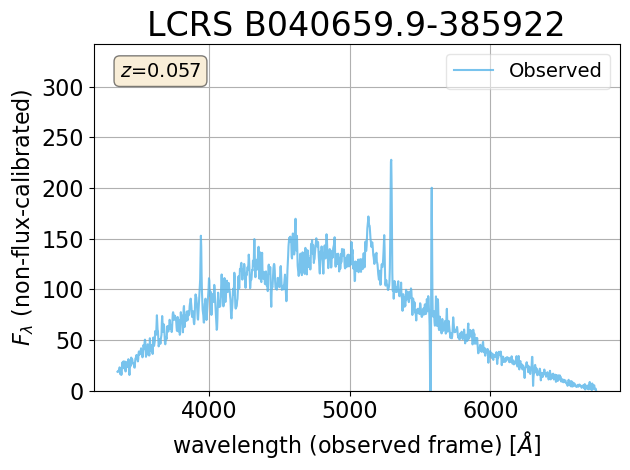

In [21]:
ax = df_obs.plot('LAMBDA', 'FLUX', c='#56b4e9', alpha=0.8, label='Observed', fontsize=18)

flux_max = df_obs.FLUX.max()
plt.ylim([0.00, 1.5*flux_max])

title = """%s""" % (lcrs_objname)
plt.title(title, fontsize=24)

ax.legend(loc='upper right', fontsize=14, framealpha=0.5)
ax.set_xlabel('wavelength (observed frame) [$\\AA$]',fontsize=16)
ax.set_ylabel('$F_{\lambda}$ (non-flux-calibrated)',fontsize=16)

ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
textstr = """$z$=%.3f""" % (z)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.grid(True)

lcrs_objname_no_spaces = lcrs_objname.replace(' ', '_')
outputFile = """LCRSspec.%s.png""" % (lcrs_objname_no_spaces)
outputFile = os.path.join(output_dirname, outputFile)

plt.tight_layout()
plt.savefig(outputFile)
